In [5]:
import sys
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from itertools import chain
from mpl_toolkits.basemap import Basemap

pt_with_text = []

def draw_map(m, scale=0.2):
    """
    Drawing world map.
    Code referenced from https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
    """
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')


def get_unix_time(inp_datetime, minutes=10, duration=60):
    """
    Get datetime of specified interval (in minutes) from input for desired duration and convert the datetimes
    to UNIX timestamp.
    Arguments:      inp_datetime = user input datetime in DD/MM/YYYY HH:MM - 24HR format
                    minutes      = specified interval, 10 minutes by default
                    duration     = specified duration, 60 minutes by default
    Returns: a list of UNIX timestamp 
    """

    date_format = datetime.strptime(inp_datetime, "%d/%m/%Y %H:%M")

    # get ten minutes before and after input datetime (for an hour)
    hour_before = [date_format-timedelta(minutes=10*i) for i in range((duration//minutes),0,-1)]
    hour_after = [date_format+timedelta(minutes=10*i) for i in range(1,(duration//minutes)+1)]  

    # convert datetime to UNIX timestamp
    hour_before.append(date_format)
    dateTime = hour_before + hour_after
    unix_time = list(map(lambda x: int(datetime.timestamp(x)), dateTime))

    return unix_time


def get_iss_location(timestamp):
    """
    Get coordinates of the location of ISS.
    Arguments:      timestamp = list of UNIX timestamp 
    Returns: a list of ISS's location 
    """

    # get ISS location
    api = 'https://api.wheretheiss.at/v1/satellites/25544/positions?timestamps={dt}&units=miles'.format(dt=','.join(map(str,timestamp)))
    request = requests.get(api).json()

    # extract timestamp, latitude and longitude
    location = [{key: request[i][key] for key in ['timestamp','latitude','longitude']} for i in range(len(request))]

    return location


def display_iss_location(locations):
    """
    Display location of ISS.
    Arguments:      locations = a list of coordinates  
    """

    print("\n{} ISS Location {}".format('='*33,'='*33))

    lon = []
    lat = []

    for i in range(len(locations)):
        dt = datetime.fromtimestamp(locations[i]['timestamp']).strftime('%d/%m/%Y %I:%M%p (UTC +0)')
        coord = (locations[i]['latitude'],locations[i]['longitude'])
        lon.append(coord[1])
        lat.append(coord[0])

        print("{}. {} - Coordinates: {}".format(i+1,dt,coord))

    # Visualize ISS location on Cylindrical Projection 
    fig = plt.figure(figsize=(8, 6), edgecolor='w')
    m = Basemap(projection='cyl', resolution=None,
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180, )
    draw_map(m)
    
    # convert to map projection coords - can be scalars, lists or numpy arrays
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)

    # label data points
    for i in range(len(lonpt)):
        point, = m.plot(xpt[i],ypt[i],'bo')  # plot blue dot
        dt = datetime.fromtimestamp(locations[i]['timestamp']).strftime('%d/%m/%Y %I:%M%p')
        text = plt.text( xpt[i]-2, ypt[i]+3, 
                         'Datetime: %s\n(%3.1fN,%5.1fW)' % (dt,latpt[i],lonpt[i]),
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=7, 
                         bbox=dict(facecolor='lemonchiffon', edgecolor='black', boxstyle='round,pad=1') )






   

    


Enter date and time (DD/MM/YYYY HH:MM - 24HR format): 23/07/2021 06:51

================================= ISS Location =================================
1. 23/07/2021 05:51AM (UTC +0) - Coordinates: (51.242277799255, -23.941618826221)
2. 23/07/2021 06:01AM (UTC +0) - Coordinates: (42.02740827974, 29.734536892402)
3. 23/07/2021 06:11AM (UTC +0) - Coordinates: (15.282573312, 59.952402751336)
4. 23/07/2021 06:21AM (UTC +0) - Coordinates: (-15.057841558453, 82.052198470653)
5. 23/07/2021 06:31AM (UTC +0) - Coordinates: (-41.820557725637, 112.04922557255)
6. 23/07/2021 06:41AM (UTC +0) - Coordinates: (-51.316349410482, 165.35675613535)
7. 23/07/2021 06:51AM (UTC +0) - Coordinates: (-33.620423381816, -149.34716706606)
8. 23/07/2021 07:01AM (UTC +0) - Coordinates: (-4.7084994214902, -124.05243770218)
9. 23/07/2021 07:11AM (UTC +0) - Coordinates: (25.25576130563, -101.08372994777)
10. 23/07/2021 07:21AM (UTC +0) - Coordinates: (48.230015751138, -63.6403083501)
11. 23/07/2021 07:31AM (UTC +0) 

SystemExit: 

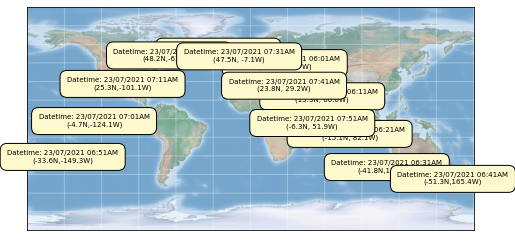

In [6]:
if __name__ == "__main__":
    
    while True:
        date_example = input('\nEnter date and time (DD/MM/YYYY HH:MM - 24HR format): ') # e.g "23/07/2021 06:51"
        valid = True
        try:
            datetime.strptime(date_example, "%d/%m/%Y %H:%M")

        except ValueError:
            valid = False

        if valid:
            dateTimes = get_unix_time(date_example, minutes=10, duration=60) # duration in minutes 
            req = get_iss_location(dateTimes)
            display_iss_location(req)
            sys.exit()
            
            
        else: 
            print('Invalid datetime, please enter again')